In [1]:
## Load required packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime

In [2]:
## define directory
dir_path = os.path.abspath('')
os.chdir('..')
from pyCiSSA.pycissa import cissa, group, cissa_outlier, build_groupings

In [3]:
## Read data file  (source is the Ministry of Economy of Spain.)
data = pd.read_excel(dir_path + r'/Hopelands_Data_20221106.xlsx')
print(data.head(5))
print(data.npID.unique())

                     sID  npID          SampleDate Value
0  Manawatu at Hopelands  NH4N 1989-09-27 10:33:00  0.01
1  Manawatu at Hopelands   DRP 1989-09-27 10:33:00  0.02
2  Manawatu at Hopelands   NO3 1989-09-27 10:33:00  1.15
3  Manawatu at Hopelands  CLAR 1989-09-27 10:33:00   0.8
4  Manawatu at Hopelands  NH4N 1989-10-11 10:20:00  0.04
['NH4N' 'DRP' 'NO3' 'CLAR' 'ECOLI' 'DO_Conc' 'SSC' 'MCI' 'ASPM' 'QMCI'
 'Chl_a' 'Dep_Sed' 'SIN']


In [4]:
## Choose parameter of interest
variable = 'Chl_a'
filtered_data = data.loc[data['npID'] == variable].reset_index(drop=True)
print(filtered_data.head(5))

                     sID   npID SampleDate  Value
0  Manawatu at Hopelands  Chl_a 2008-12-11    135
1  Manawatu at Hopelands  Chl_a 2009-01-13  124.8
2  Manawatu at Hopelands  Chl_a 2009-02-11   1.45
3  Manawatu at Hopelands  Chl_a 2009-03-03    8.5
4  Manawatu at Hopelands  Chl_a 2009-04-20    195


In [5]:
## fix the censored values
def remove_censoring(df,valuecolumn = 'Value', strings_to_replace = ['<','>']):
    '''
    Function to take a pandas dataframe and remove unwanted strings from the column.
    Useful for removing censoring...

    Parameters
    ----------
    df : pandas dataframe
        DESCRIPTION: Input pandas dataframe which contains column to remove strings from
    valuecolumn : string, optional
        DESCRIPTION: The default is 'value'. Column name in the dataframe which we want to remove the defined strings from
    strings_to_replace :  list, optional
        DESCRIPTION: The default is '['<','>']'. List of strings which we want to remove from the data   
        
    Returns
    -------
    df : pandas dataframe
        DESCRIPTION: Output pandas dataframe which contains a new column with the strings of interest removed
    '''

    
    #check valuecolumn is in the dataframe columns
    if not valuecolumn in list(df.columns):
        raise Exception(f'Column: {valuecolumn} not found in this dataframe')
    
    new_column = []
    #Iterate through dataframe values
    for value_n in df[valuecolumn]:
        string = ''
        #make value a string
        string = str(value_n)
        
        #replace unwanted characters 
        for str_i in strings_to_replace:
            string = string.replace(str_i, '')
        
        try: #try to append float value 
            new_column.append(float(string))
        except: #if making float fails, just append the original value    
            new_column.append(value_n)
    
    #Add new column to dataframe
    df['uncensored_value'] =   new_column
    return df       



uncensored_data = remove_censoring(filtered_data)


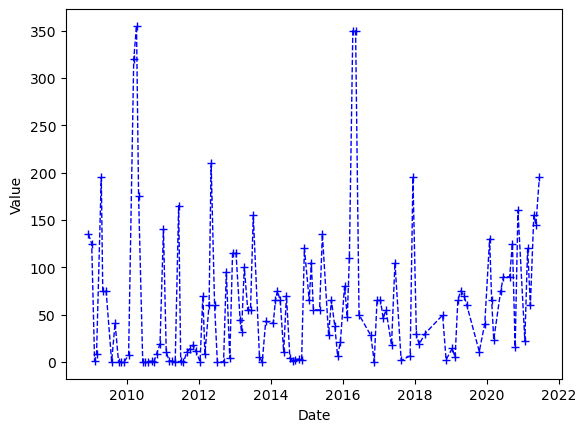

In [6]:
## Plot the data
plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--+', lw=1.0)
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [7]:
## Add in year and month
uncensored_data['year'] = uncensored_data['SampleDate'].dt.year
uncensored_data['month'] = uncensored_data['SampleDate'].dt.month
uncensored_data.head()

,sID,npID,SampleDate,Value,uncensored_value,year,month
0,Manawatu at Hopelands,Chl_a,2008-12-11,135,135.00,2008,12
1,Manawatu at Hopelands,Chl_a,2009-01-13,124.8,124.80,2009,1
2,Manawatu at Hopelands,Chl_a,2009-02-11,1.45,1.45,2009,2
3,Manawatu at Hopelands,Chl_a,2009-03-03,8.5,8.50,2009,3
4,Manawatu at Hopelands,Chl_a,2009-04-20,195,195.00,2009,4


In [8]:
## Minimum year, month
min_year = uncensored_data['year'].min()
min_month = uncensored_data.loc[uncensored_data['year'] == min_year]['month'].min()

max_year = 2021
max_month = uncensored_data.loc[uncensored_data['year'] == max_year]['month'].max()

print(min_month,min_year)
print(max_month,max_year)

12 2008
6 2021


In [9]:
## Replace missing values
missing_value = -1

data_with_missing_replaced = pd.DataFrame(columns = ['date', 'value', 'missing'])

for year_i in range(min_year,max_year+1):
    start_month = 1
    end_month = 12
    if year_i == min_year:
        start_month = min_month
    if year_i == max_year:
        end_month = max_month
        
    for month_i in range(start_month,end_month+1):
        temp_row,temp_date = None,None
        temp_date = datetime.datetime(year_i, month_i, 15)
        temp_row = uncensored_data.loc[(uncensored_data['year'] == year_i) & (uncensored_data['month'] == month_i)]
        
        if len(temp_row) == 0:
            data_with_missing_replaced.loc[len(data_with_missing_replaced)] = [temp_date,missing_value,1]
        else:
            data_with_missing_replaced.loc[len(data_with_missing_replaced)] = [temp_date,np.median(temp_row['uncensored_value']),0]
                
data_with_missing_replaced.head()    

print(f'Percent of missing values = {100*len(data_with_missing_replaced.loc[data_with_missing_replaced["missing"] == 1])/len(data_with_missing_replaced)}')
        

Percent of missing values = 18.543046357615893


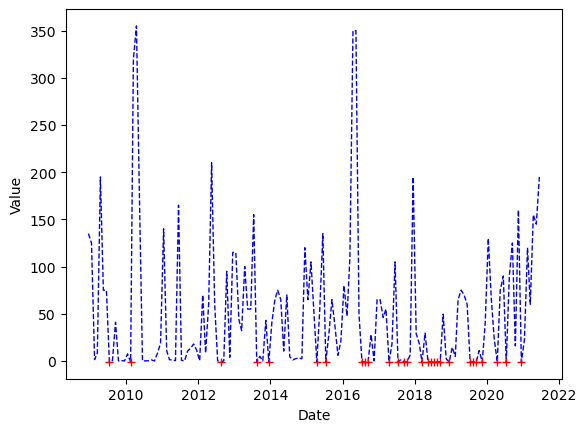

In [10]:
## Missing rows only
missing_rows = data_with_missing_replaced.loc[data_with_missing_replaced['missing'] == 1]
x = list(missing_rows.index)

## Plot the data including missing values
plt.plot(data_with_missing_replaced['date'], data_with_missing_replaced['value'], 'b--', lw=1.0)
plt.plot(missing_rows['date'], missing_rows['value'], 'r+', lw=1.0)
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [11]:
#CiSSA parameters
L = 12*5
data_per_year = 12

## Define error correction parameters
outliers = ['<',0]  #any value < -1 is an outlier/missing value
errors = ['value', 5]  #converge until error < 50
eigenvalue_proportion = 0.995 

In [12]:
## Apply cissa_outliers to check the reconstricted signal
## run pyCiSSA with outliers
x_ca, x_casa, rc = cissa_outlier(data_with_missing_replaced['value'],L,data_per_year,data_per_year,outliers = outliers,errors = errors, eigenvalue_proportion = eigenvalue_proportion)

Initial guess for outliers: [44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44.
 44. 44. 44. 44. 44. 44. 44. 44. 44. 44.]
New points: [44.56359146 43.37270073 40.07713347 39.56820921 39.22851194 38.33048861
 49.506005   48.24803472 39.76814013 48.22202798 39.89796463 47.9870009
 47.86826556 40.17555268 47.45591434 47.25063222 40.86319419 47.04657444
 41.09728099 46.78383964 41.63115717 45.35273793 42.78045049 45.09980707
 44.87722649 43.38010563 44.5658687  43.44663242]
Consecutive prediction error: 5.6695113888889 vs target error: 5
New points: [45.05318351 42.84566189 36.47740717 35.61222803 34.99034258 33.41122437
 54.22733905 51.60744776 36.43110517 51.54522327 36.71584238 51.04946609
 50.81167502 37.27467604 50.00370773 49.60329642 38.61726426 49.21130531
 39.06549622 48.70809199 40.08359083 45.97127832 42.2814526  45.49348221
 45.078621   43.36023483 44.57161353 43.39355301]
Consecutive prediction error: 4.91926424432539 vs target error: 5
iteration: 2, error

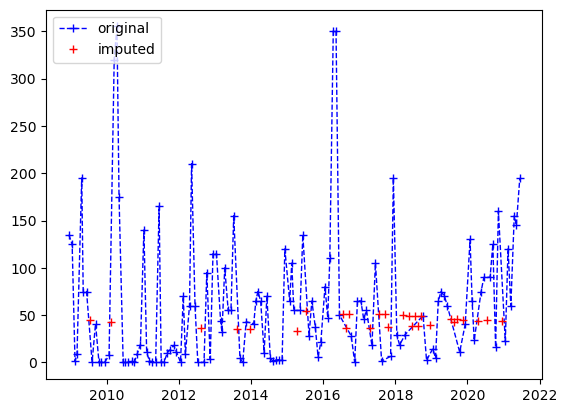

In [13]:

#plt.plot(data_with_missing_replaced['date'], data_with_missing_replaced['value'], 'b', lw=1.0, label = 'original')
plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--+', lw=1.0, label = 'original')
plt.plot(data_with_missing_replaced.loc[x,'date'], x_ca[x], 'r+', lw=1.0, label = 'imputed')
plt.legend(loc="upper left")

In [18]:
## Build grouping cell
Z,psd = cissa(x_ca,L)
period_ranges = {}
period_ranges.update({'long term cycle': [4,5]})
period_ranges.update({'seasonality': [0.9,1.1]})
I  = build_groupings(period_ranges,data_per_year,psd,Z,include_noise = True)
#2) Group components
rc, sh, kg = group(Z,psd,I)
print(sh)
print(kg)

{'long term cycle': 5.684385958206443, 'seasonality': 19.3951004897845, 'trend': 0.6092485808724055, 'noise': 74.04587481942916}
{'long term cycle': array([1]), 'seasonality': array([4, 5]), 'trend': array([0]), 'noise': array([ 2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29])}


dict_keys(['long term cycle', 'seasonality', 'trend', 'noise'])


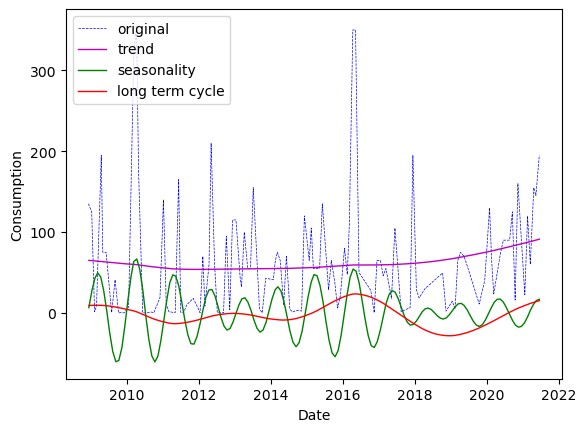

In [19]:
##plot trend, seasonality, long term cycle

print(rc.keys())

plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--', lw=0.5, label = 'original')
plt.plot(data_with_missing_replaced['date'], rc['trend'], 'm', lw=1.0, label = 'trend')
plt.plot(data_with_missing_replaced['date'], rc['seasonality'], 'g', lw=1.0, label = 'seasonality')
plt.plot(data_with_missing_replaced['date'], rc['long term cycle'], 'r', lw=1.0, label = 'long term cycle')
#plt.plot(data_with_missing_replaced['date'], rc['noise'], 'k', lw=1.0, label = 'noise')
plt.legend(loc="upper left")
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.show()

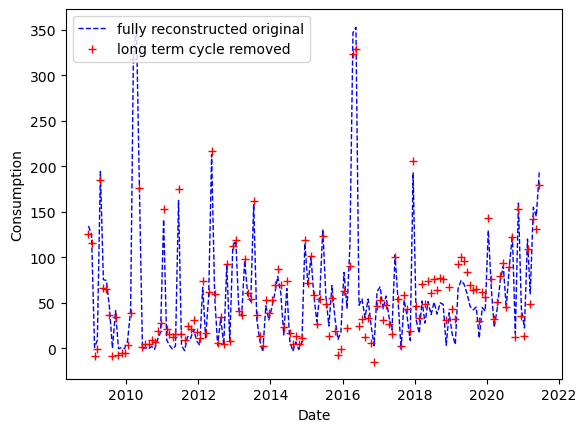

In [20]:
##plot data without long term cycle
rc_all = np.zeros(rc['trend'].shape)
rc_reduced = rc_all.copy()
for rc_i in rc.keys():
    rc_all += rc.get(rc_i)
    if not rc_i == 'long term cycle':
        rc_reduced += rc.get(rc_i)

#plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--', lw=0.5, label = 'original')
plt.plot(data_with_missing_replaced['date'], rc_all, 'b--', lw=1.0, label = 'fully reconstructed original')
plt.plot(data_with_missing_replaced['date'], rc_reduced, 'r+', lw=1.0, label = 'long term cycle removed')
plt.legend(loc="upper left")
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.show()


In [21]:
sh

{'long term cycle': 5.684385958206443,
 'seasonality': 19.3951004897845,
 'trend': 0.6092485808724055,
 'noise': 74.04587481942916}